# DSML Team Assignment
## Pecan Street Electricity Analysis
### *[Texas, Austin AND 2005]*
*The Pecan Street datasets contains *
#### 'households.csv'

*General description*

The households.csv dataset contains the hourly load values for 294 households for the period from 01.01.2014  - 01.12.2016. These households all live on the Pecan Street in Austin, Texas; crucially some of them also have solar panels on their houses. The dataframe has  294 rows and 8759 columns (one hourly measurement was a duplicate). The index of the dataset is the household numbers. Each row contains the hourly load values for a specific household. There is thus one column for every household


*Variables*

We have one variable for each household


          
#### 'weather.csv'

*General description*

.The weather.csv dataset gives us a detailed overview of the weather from the period from 10.06.2012 09:00:00 – 18.01.2018 23:00:00. We have the hour as the index of the dataset.

*Variables*




| Variable | Description | Unit |
|------|------|------|------|
|temperature|mean temperature|Fahrenheit|  
|wind speed|hourly wind speed readings as float|mph|  
|summary|hourly qualitative assessment of weather as string|n/a|   
|cloud_cover|ratio of “cloudiness” in hourly intervals as float from 0 to 1 |n/a|  

          

## PREP - Data Exploration & Cleaning ##

In this section we will mainly fill missing values and adjust the indicies of both dataframes to match each other.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

Library use cases:<br>
__datetime__: used for converting the indexes of our datasets to later resample (group) the data on daily and quarterly basis.<br>
__pandas__: used for performing operations on the datasets.<br>
__numpy__: used for performing mathematical operations on the data. Contains a lot of useful methods.<br>
__matplotlib.pyplot__: used for building basic 2D plots.<br>
__sklearn.linear_model.Ridge__: used for performing a ridge regression on a data cluster in the part C.<br>
__sklearn.linear_model.Lasso__: used for performing a lasso regression on a data cluster in the part C.<br>
__sklearn.linear_model.LinearRegression__: used for performing linear regressions on different data.<br>
__sklearn.cluster.KMeans__: used in an attempt to cluster the data using the KMeans++ algorithm.<br>
__sklearn.mixture.GaussianMixture__: used for dividing the data into clusters.<br>
__sklearn.preprocessing.PolynomialFeatures__: used for transforming a matrix of inputs into a matrix with polynomial inputs.<br>
__sklearn.metrics.mean_squared_error__: used for determining the MSE of regression models.<br>
__sklearn.model_selection.train_test_split__: used for cross-validating the models by splitting the dataset into a training set and a test set.<br>
__mpl_toolkits.mplot3d.Axes3D__: used for building 3D plots.

Read weather.csv, filter by the year 2015 and trim the timestamps.

In [2]:
weather_all = pd.read_csv("weather.csv", index_col=0)
weather = weather_all[list(map(lambda x : str(x)[0:4] in ['2015'], weather_all.index))].copy()
weather.index = list(map(lambda x : str(x)[0:-3], weather.index))
weather.index = pd.to_datetime(weather.index)

Read households.csv, filter by the year 2015, drop the houses without data for this year and trim the timestamps to match the weather dataframe timestamps. Remove the duplicate indices.

In [3]:
households_all = pd.read_csv("households.csv", index_col=0)

In [4]:
households = households_all.T[list(map(lambda x : str(x)[0:4] in ['2015'], households_all.T.index))].copy()
households.dropna(axis=1, how='all', inplace=True)
households.index = list(map(lambda x : str(x)[0:-6], households.index))
households.index = pd.to_datetime(households.index)
households = households[~households.index.duplicated()]

We are filling the missing values of one household with the mean for this household over the whole dataset; 
this is a useful approach because we don't have a very large dataset and can thus maintain a higher dataset 
size.

In [5]:
households.fillna(value=households.mean(), inplace=True)

In addition, we would like to figure out the consumption pattern of the whole street, which is why  we add a total and a variation column.

In [6]:
households['total'] = households.sum(axis=1) 
households["variation"]=households.iloc[:, 0:-1].apply(np.var, axis =1) 

In [7]:
households.head()

,26,77,86,93,101,114,115,160,171,187,...,9932,9933,9934,9935,9938,9942,9971,9982,total,variation
2015-01-01 00:00:00,2.048900,2.826817,0.789183,1.651917,0.312050,0.626667,0.208517,0.182750,0.798817,0.818250,...,0.316750,4.085933,5.953017,13.989517,4.381033,0.612700,2.453783,0.158800,319.054974,1.431685
2015-01-01 01:00:00,1.515517,1.359167,0.809000,0.581400,0.282583,0.595783,0.955900,0.181733,0.519833,0.853683,...,0.319417,2.916267,2.118150,11.283333,4.829950,0.433100,2.028883,0.213433,302.265124,1.137151
2015-01-01 02:00:00,0.766217,1.660367,0.800317,0.748617,0.279317,0.478883,0.847267,0.170433,0.473567,0.828250,...,0.313517,1.849967,0.838250,10.172733,4.041900,0.481367,1.714033,0.227617,291.405224,1.196879
2015-01-01 03:00:00,0.457633,2.714217,0.843017,0.388733,0.279500,0.312283,0.413633,0.149883,0.508167,0.858500,...,0.318333,1.954267,1.206183,17.577583,4.075100,0.426967,1.823217,0.274617,287.924474,1.938287
2015-01-01 04:00:00,0.403050,3.516467,0.789433,0.667600,0.276950,0.318917,1.669883,0.118867,0.645967,0.808383,...,0.442733,1.982317,1.444817,10.458317,3.945583,0.445150,3.323383,0.263150,297.420408,1.536487


The households dataframe looks nice now, let's examine the weather dataframe.

In [8]:
weather.head()

,summary,temperature,wind_speed,cloud_cover
2015-01-01 00:00:00,Light Rain,37.80,5.27,1.00
2015-01-01 01:00:00,Light Rain,37.99,4.74,0.95
2015-01-01 02:00:00,Light Rain,37.66,4.85,0.90
2015-01-01 03:00:00,Light Rain,36.84,4.78,0.87
2015-01-01 04:00:00,Light Rain,36.56,4.56,0.90


Let's check out if we can use the variable summary directly.

In [9]:
weather["summary"].unique()

array(['Light Rain', 'Drizzle', 'Overcast', 'Mostly Cloudy', 'Rain',
       'Partly Cloudy', 'Clear', 'Light Snow', 'Flurries',
       'Snow (Under 1 in.)', 'Foggy', 'Humid and Overcast',
       'Humid and Mostly Cloudy', 'Humid and Partly Cloudy', 'Humid',
       'Dry', 'Heavy Rain'], dtype=object)

Although it is informative, the nominal data type is difficult to work with. Besides, it 
depicts mostly whether it rains or not, which is not our priority interest.



Copy the 'total' column from the households to the weather data frame and call it 'load'. Convert the weather data frame index to Datetime Index in order to be able to resample the dataframe in the next step. Now resample (group) the data daily and quarterly using mean values for all columns.

## PART A - Analysis


We now have to analyse the reasons for daily and seasonal variance. First we "join" the dataframes by adding the "total" column to the weather dataframe.  
Afterwards we resample the data to answer the questions: We create a daily weather dataframe for answering the daily variance question, and a monthly and quarterly dataframe because both can help us answer questions regarding seasonal variance.

In [10]:
#use sum because it's slightly more appropriate than the mean for households data
households_day = households.resample("D").sum() 
weather['load'] = households['total'].values 

#most of the data in the weather dataframe is more amenable to a mean operation (it does not make 
#sense to sum the cloud_covers)
weather_day = weather.resample('D').mean() 
weather_monthly = weather.resample("M").mean()
weather_quarter = weather.resample('Q').mean() 

In [11]:
weekday = list(map(lambda x : x.weekday() <= 4, weather_day.index))
weather_day["weekday"] = weekday

In [12]:
weather_day.head()

,temperature,wind_speed,cloud_cover,load,weekday
2015-01-01,37.462500,5.017500,0.946667,379.409922,True
2015-01-02,40.301250,5.096250,0.907083,349.723870,True
2015-01-03,45.623333,3.192500,0.403333,179.440088,False
2015-01-04,41.896250,6.229583,0.029167,192.188875,False
2015-01-05,38.672917,2.710417,0.123333,211.761913,True


Now we can begin to look for possible reasons for the variation; we first look at some correlations between 
the load and the other features, both on a monthly and daily basis

In [13]:
temp_corr = weather_day['load'].corr(weather_day['temperature'])
wind_corr = weather_day['load'].corr(weather_day['wind_speed'])
cloud_corr = weather_day['load'].corr(weather_day['cloud_cover'])   
cloud_corr_month = weather_monthly["cloud_cover"].corr(weather_monthly["load"]) 
temp_corr_month = weather_monthly["load"].corr(weather_monthly["temperature"]) 
temp_cloud_corr_month = weather_monthly["cloud_cover"].corr(weather_monthly["temperature"])

weekday_corr = weather_day["load"].corr(weather_day["weekday"]) 

#Conclusion: no relationship between weekday and load
weekday_corr_var = households_day["variation"].corr(weather_day["weekday"])

var_corr = weather['load'].corr(households['variation'])  

print("load_temperature correlation:",temp_corr)  
print("load_wind correlation:",wind_corr) 
print("load_cloud correlation:",cloud_corr) 
print("load_variance correlation:",var_corr) 
print("load_cloud monthly correlation:",cloud_corr_month) 
print("load_weekday correlation:",weekday_corr)  
print("load_weekday_monthly correlation:",weekday_corr_var)  
print("load_temperature_monthly correlation:",temp_corr_month) 
print("cloud_temperature monthly correlation:",temp_cloud_corr_month) 

load_temperature correlation: 0.560365147365
load_wind correlation: 0.187373918025
load_cloud correlation: 0.00318325944594
load_variance correlation: -0.152342023578
load_cloud monthly correlation: -0.719122457638
load_weekday correlation: -0.0542829184654
load_weekday_monthly correlation: -0.03625396605
load_temperature_monthly correlation: 0.818291008187
cloud_temperature monthly correlation: -0.472108069209


# Preliminary results: 

# 1: Positive relationship between temperature and load
What do these values tell us? Firstly, it seems obvious that temperature is correlated with load. When the temperature is higher, people use ACs more frequently. However, it's striking that the correlation on the monthly basis is 0.81, while on a daily basis it's only 0.56 



# 2. Very weird relationship between cloud_cover and load: 
On a monthly basis we see that the correlation is very strong: -0.71. This is  suprising as the more sun 
shines (which means a lower cloud cover) the more energy is produced by the solar panes which should reduce load. However on a daily basis we see that the correlation between cloud_cover and temperature is only 0.003! 
This is a big difference, which we will investigate later on.

# 3. There is a very low correlation between weekday and load: 
We could have expected that the consumption patterns between weekday and weekend days are different because 
more people are at home, do other things than during the week. However, we do not see a strong  correlation. Of course the correlation coefficient has it's limitations, because it can not pick up every 
form of relationship within data.

# Investigate the relationsheep between weekday and load:

First let's take a look at the different means

In [14]:
print('Mean weekend load:', weather_day[weather_day["weekday"]==False]["load"].mean())
print('Mean weekday load:', weather_day[weather_day["weekday"]==True]["load"].mean()) 

Mean weekend load: 278.385002162
Mean weekday load: 263.918620598


The mean for weekends is a little bit higher, but let's plot the relationship

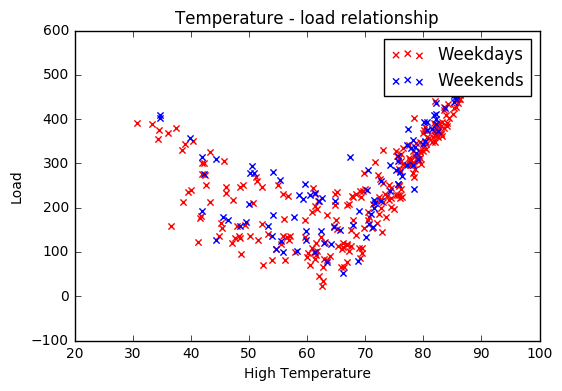

In [15]:
%matplotlib inline
plt.scatter(weather_day[weather_day["weekday"]==True]["temperature"], 
            weather_day[weather_day["weekday"]==True]["load"], marker='x', color='r')
plt.scatter(weather_day[weather_day["weekday"]==False]["temperature"], 
            weather_day[weather_day["weekday"]==False]["load"], marker='x', color='b')
plt.xlabel("High Temperature")
plt.ylabel("Load")
plt.legend(["Weekdays", "Weekends"]) 
plt.title('Temperature - load relationship')
plt.show()

The patterns seem to be extermely similar, with weekends having a slightly but consistently higher load. 
Because the production side of the load (the solar panels on people's houses) is unaffected by a weekend, 
we can conclude that people consume more on weekends, probably because they spend more time at home as they are not at work.

# First result: On weekends there is a slightly higher load, presumably because people consume more energy due to increased time at home.

# Investigate the relationship between temperature, clouds, windspeed and load:

We had a few questions based on the correlations: the correlation on a daily basis between cloud and load seems to be very low  and contrary to our expectations: we would expect a positive relationship between clouds and 
load ( more clouds -> less sun -> less solar energy -> more load)



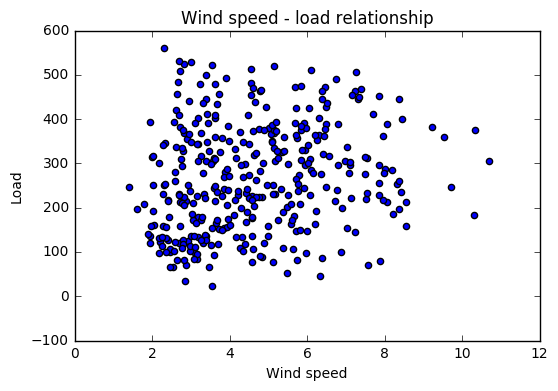

In [16]:
plt.scatter(weather_day['wind_speed'], weather_day['load'])
plt.xlabel('Wind speed')
plt.ylabel('Load')
plt.title('Wind speed - load relationship')
plt.show()

The correlation between wind speed and load was low and this plot also looks like there is no real relationship.
We will therefore not consider wind speed any further.

__Let's plot the temperature load relationship__:

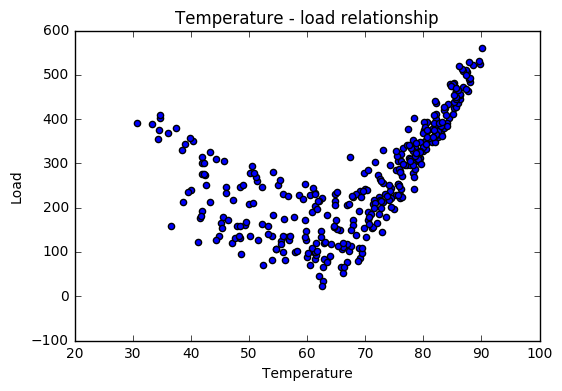

In [17]:
plt.xlabel('Temperature')
plt.ylabel('Load')
plt.title('Temperature - load relationship')
plt.scatter(weather_day['temperature'], weather_day['load'])
plt.show()

We see a pattern where low temperatures lead to higher load, medium temperatures lead to a very low load, and high temperatures lead to the highest loads.

This pattern seems to be explained quite easily. 40 degrees Fahrenheit (which is the lower end of the temperature distribution in our data) are around 4 degrees celsius, which means people will use heating at that point, which will increase load. They use less and less heating as the temperatures approach 60 degrees Fahrenheit; in addition to that the exposure of the solar panels to sun increases producing lower load. 
With the high temperatures the load increases again, because people use air conditioning. 

__*Relationship between cloud cover and temperature*__

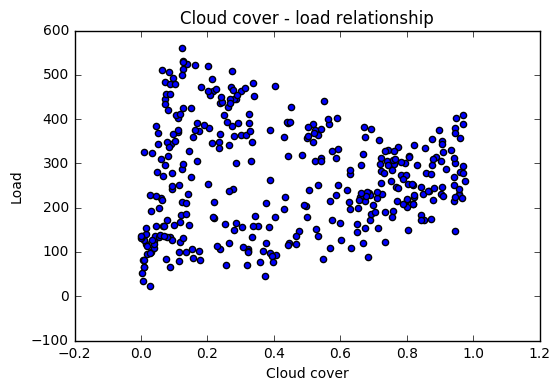

In [18]:
plt.xlabel('Cloud cover')
plt.ylabel('Load')
plt.title('Cloud cover - load relationship')
plt.scatter(weather_day['cloud_cover'], weather_day['load'])
plt.show()

This looks very messy. We can probably see that at high cloud cover values there seems to be a concentration of 
medium values for load, but at low cloud cover the load has a very big spread.

__*Relationship between cloud cover and temperature on a monthly basis*__

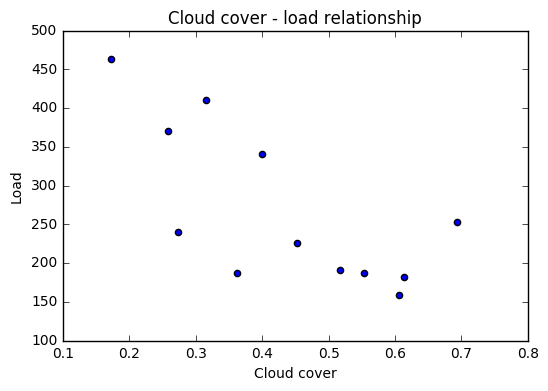

In [19]:
plt.xlabel('Cloud cover')
plt.ylabel('Load')
plt.title('Cloud cover - load relationship')
plt.scatter(weather_monthly['cloud_cover'], weather_monthly['load'])
plt.show()

This is really not conclusive, we probably have too few months in the dataset to conclude anything on a monthly 
basis

It seems very likely that the relationship between load and cloud cover is in some way influenced by the temperature. A lower cloud cover would lead to more produced solar energy which would lead to a lower load. But on the other hand a lower cloud cover would increase temperature because of greater sunshine which in turn might increase the load. 

So let's try to do a 3d plot

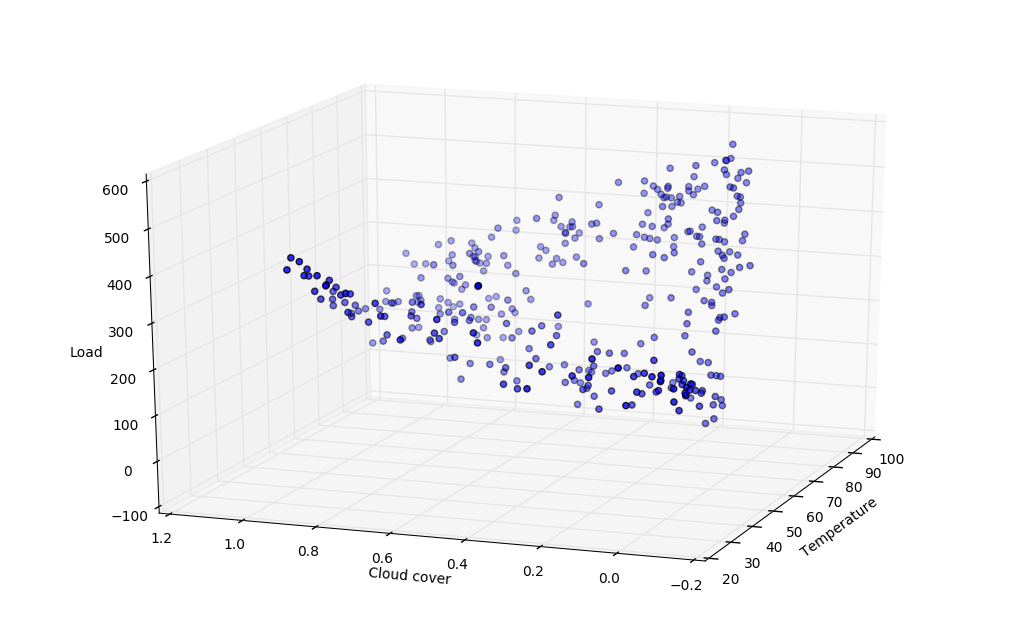

In [20]:
fig = plt.figure(figsize=(13,8))  
ax1 = fig.add_subplot(111, projection = '3d')  
ax1.scatter(weather_day['temperature'], weather_day["cloud_cover"], weather_day['load'])  
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Cloud cover") 
ax1.set_zlabel("Load") 
ax1.view_init(19, -160)  

If we squint hard, we can see that for low temperatures the relationship between cloud_cover and load is positive, while for high temperatures it is negative. 
We will try to confirm this impression by binning the data.

We will bin the data into three categories, differentiating between low, medium and high temperatures, and 
see whether we can find a relationship there.

In [21]:
#df=pd.cut(weather_day["temperature"],bins=5, labels = ["very low", "low", "medium", "high", "very high"] )  
df=pd.cut(weather_day["temperature"],bins=3, labels = ["very low",  "medium", "very high"]) 
nums=pd.cut(weather_day["temperature"],bins=3, labels = ["1",  "2", "3"])
weather_day["temp_category"] = df
weather_day["temp_category_num"] = nums

/home/ligang/anaconda3/envs/getting_rich/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


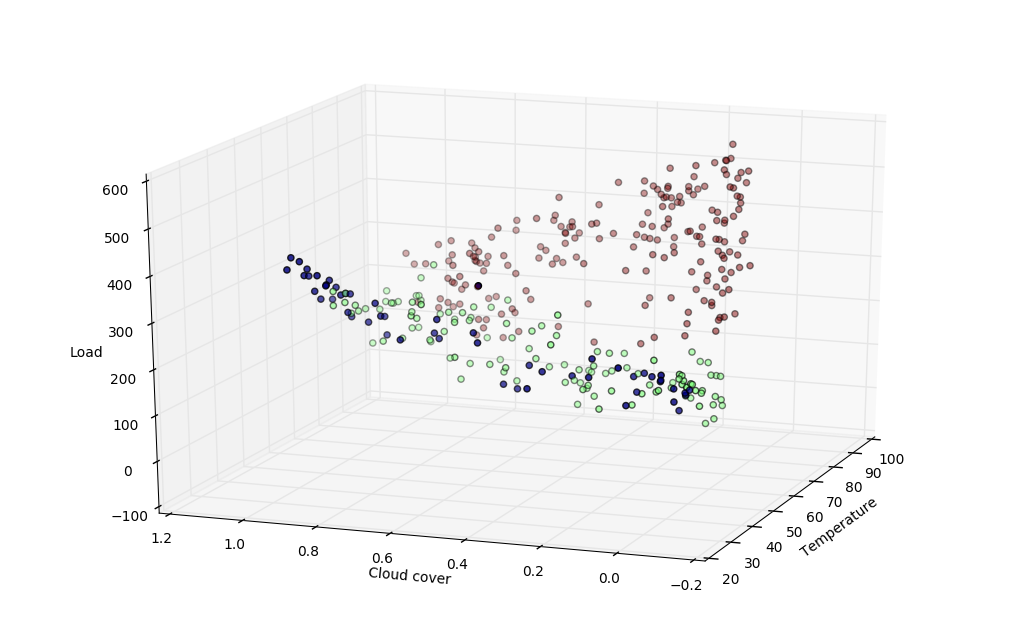

In [22]:
fig = plt.figure(figsize=(13,8))  
ax1 = fig.add_subplot(111, projection = '3d')  
ax1.scatter3D(weather_day['temperature'], weather_day["cloud_cover"], weather_day['load'], c=weather_day['temp_category_num'])
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Cloud cover")
ax1.set_zlabel("Load") 
ax1.view_init(19, -160)

__For high temperature values (colored in yellow) we see a positive relationship between cloud cover 
while for low to medium temperatures we see a negative relationship.__  (note that the cloud cover axis goes from 1 to 0)

We shall now drill down by plotting the relationship for each tempeature category seperately and by calculating correlations.

In [79]:
def cor(weather_day, title_plot = None):  
    """
    we use this function to compute a correlation between load and temperature and cloud coverage and to plot 
    the relationship
    """
    print("######") 
    temp_corr = weather_day['load'].corr(weather_day['temperature'])
    cloud_corr = weather_day['load'].corr(weather_day['cloud_cover'])   
    plt.xlabel("Cloud cover") 
    plt.ylabel("Load")  
    title = weather_day["temp_category"][0] 
    if  title_plot: 
        title = title_plot
    plt.title("Cloud - load correlation for " + title + " temperature" )
    plt.scatter(weather_day["cloud_cover"], weather_day["load"]) 
    plt.show()
    print("Mean temperature:",weather_day["temperature"].mean()) 
    print("Correlation for temperature:" , temp_corr) 
    print("Correlation for cloud cover:" , cloud_corr) 


######


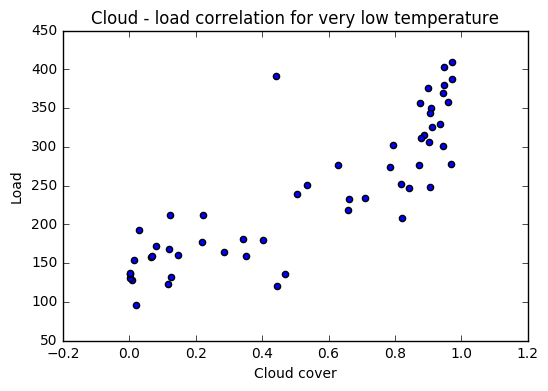

Mean temperature: 42.9862808642
Correlation for temperature: -0.704866540289
Correlation for cloud cover: 0.846803456097
######


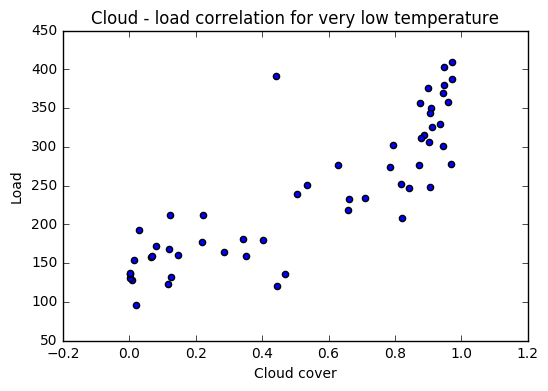

Mean temperature: 42.9862808642
Correlation for temperature: -0.704866540289
Correlation for cloud cover: 0.846803456097
######


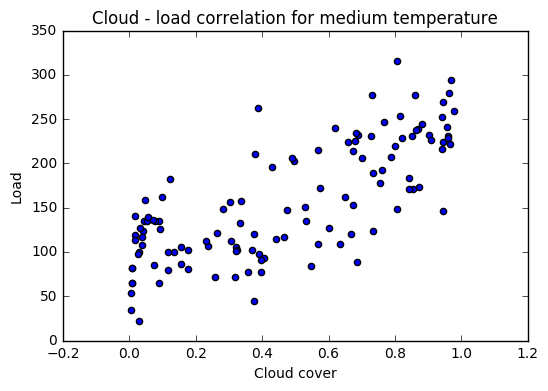

Mean temperature: 61.8070504506
Correlation for temperature: -0.101461086361
Correlation for cloud cover: 0.750362365184
######


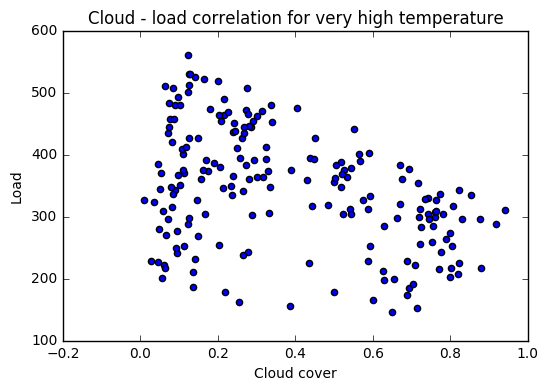

Mean temperature: 79.7161957465
Correlation for temperature: 0.942354218518
Correlation for cloud cover: -0.410513944969
######


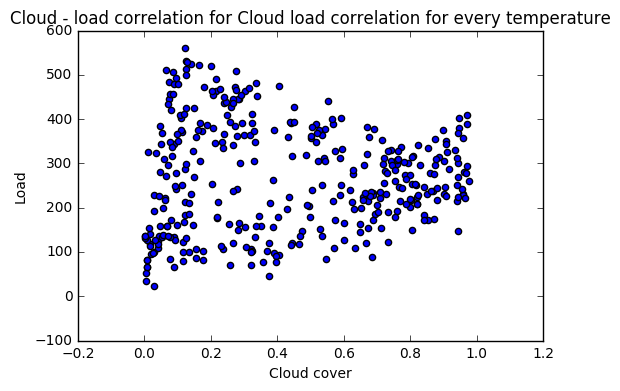

Mean temperature: 68.443308914
Correlation for temperature: 0.560365147365
Correlation for cloud cover: 0.00318325944594


In [83]:
weather_day.groupby("temp_category").apply(cor)
cor(weather_day, title_plot = "Cloud load correlation for every")

__These are great and interesting results!__:  



We can conclude the following: for low temperatures we see a positive relationship between clouds and load, while we see a negative relationship between temperature and load. 

__Reason__: There are quite likely two mechanisms at work here: There is a direct and indirect influence of the
cluod cover on the load. The direct influence is increased solar production with less clouds; but since there 
is also a strong negative correlation between temperature and load, we can safely assume that less clouds lead 
to higher temperatures, which in turn lead to less need for heating. 


__Medium_temperatures__: 
We see a very weak correlation between temperature and load, while we see a high (0.87) correlation between load and cloud cover.  

__Possible Reason__: Very few people use heating or air conditioning at those temperatures, an increase from 13 to 18 degrees has thus very little effect. However, the production of more solar energy is still going on with less clouds. Thus we can conclude that cloud_cover has an  effect on load that is independent of the temperature 

__High temperatures__: Extremely strong positive correlation between temperature and load, and medium negative correlation between load and cloud cover 

__Possible Reason__: People now use AC again, so when temperatures rise the ACs have to work more. The previous positive effect of clouds on load is now gone, because the direct effect of more energy through solar panels 
is drowned out by the indirect effect of temperature on load. Presumambly, solar panels are just not capable of producing enough energy (or not enough houses have solar panels)

We will now try to confirm our hypotheses from before by looking at a night hour (where no sun is present) 
and a day hour 

In [25]:
def cor_light(weather_day):  
    """
    this helps us to compute the correlation between cloud coverage and temperature,and plot this
    """
    print("######") 
    
    temp_corr = weather_day['load'].corr(weather_day['temperature'])
    cloud_corr = weather_day['load'].corr(weather_day['cloud_cover'])   
    plt.xlabel("Cloud Cover") 
    plt.ylabel("Load")
    plt.title('Cloud cover - load relationship')
    #plt.title("cloud load correlation for  " +  title + " temperature" )
    plt.scatter(weather_day["cloud_cover"], weather_day["load"]) 
    plt.show()
    print("mean temperature: ",weather_day["temperature"].mean()) 
    print("correlation for temperature:" , temp_corr) 
    print("correlation for cloud:" , cloud_corr) 


In [26]:
weather.index.name = "dates"
w_dark =weather[weather.index.map(lambda x: x.hour in [21,22])  ] 
w_light =weather[weather.index.map(lambda x: x.hour in [12,11])  ] 
df=pd.cut(weather["temperature"],bins=3, labels = ["very low",  "medium", "very high"]) 
nums=pd.cut(weather["temperature"],bins=3, labels = ["1",  "2", "3"])
weather["temp_category"] = df
weather["temp_category_num"] = nums

######


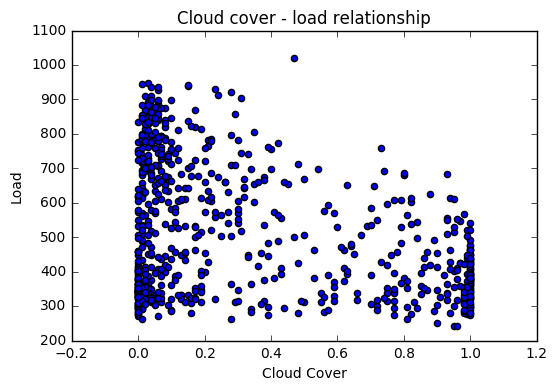

mean temperature:  68.2187808219
correlation for temperature: 0.775380565948
correlation for cloud: -0.352002840583
######


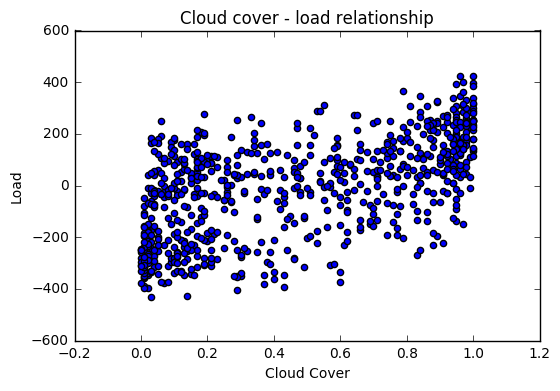

mean temperature:  71.6462191781
correlation for temperature: 0.0149361240435
correlation for cloud: 0.577641891105


In [27]:
cor_light(w_dark) 
cor_light(w_light)

Indeed we find that that during 12 pm the relationship between cloud cover and load is positive, and even higher than the temperature relationship, while at night temperature is more important. This is expected 
because no sun shines at night.

But the negative relationship between cloud_cover and load at night is somewhat surprising as we wouldn't expect any relationship: Not a direct one because of obvious reasons, but even an indirect one through the temperature would be weird: the sun is not shining so why should cloud covers affect the temperature and thus the load? However, this question will not be investigated further.

For the whole dataset we had a positive relationship between temperature and load, but we saw that it actually depends on how high the temperature is. This is explained by the distribution of temperatures in the dataset: 

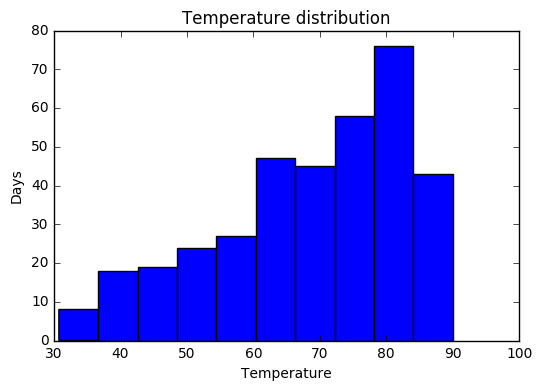

In [28]:
plt.hist(weather_day["temperature"])
plt.xlabel('Temperature')
plt.ylabel('Days')
plt.title('Temperature distribution')
plt.show()

Let's conclude our analysis of daily variance by looking at the correlation between temperature and load 
at night vs  day, just to confirm our earlier conclusions. 

Correlation matrix for temperature and load at night:
 [[ 1.          0.77538057]
 [ 0.77538057  1.        ]]


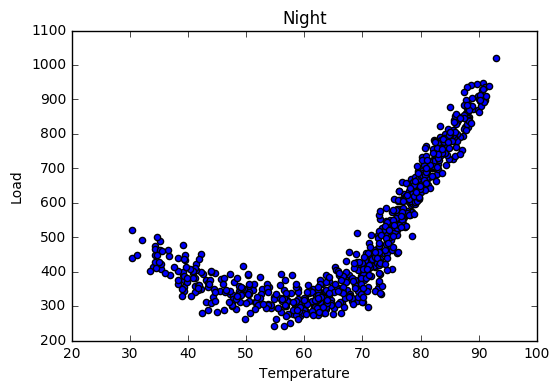

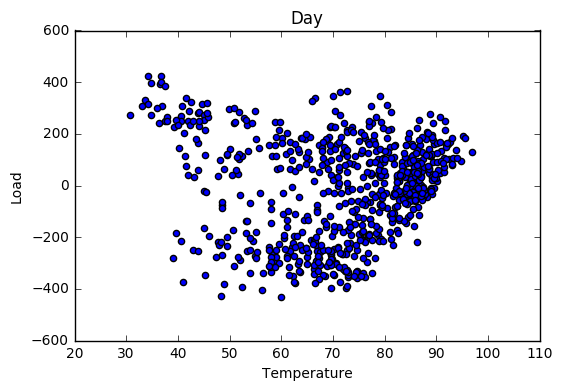

In [29]:
print("Correlation matrix for temperature and load at night:\n", np.corrcoef(w_dark["temperature"], w_dark["load"]))
plt.scatter(w_dark["temperature"], w_dark["load"])
plt.xlabel('Temperature')
plt.ylabel('Load')
plt.title('Night')
plt.show()
plt.scatter(w_light["temperature"], w_light["load"])
plt.xlabel('Temperature')
plt.ylabel('Load')
plt.title('Day')
plt.show()

For temperature we see that the relationship indeed is very strong at night, but during the day it is very messy, because cloud cover also plays a role. 



We would like to examine how much variance is being explained by our hypothesis by performing a Linear Regression on the 
daily dataset. We use a Polynomial Regression because the results of a regression are highly interpretable and we use degree = 2 because we both saw a seemingly quadratic plot for temperature~load and also saw an interaction effect between cloud_cover and temperature.

We choose to not normalize the data for this regression because a regression is robust to not normalized data.

In [30]:
X = weather_day.loc[:, ["cloud_cover", "temperature"]]  
X = np.array(X) 
Y = weather_day["load"]  
Y = np.array(Y) 

The PolynomialFeatures class includes interaction_terms automatically which is why we choose it.

In [31]:
poly_reg = PolynomialFeatures (degree = 2)
# Polynomial transformation
x_poly = poly_reg.fit_transform(X) 
lin_reg_Poly = LinearRegression()

# Fitting linear regression to polynomial features
fit=lin_reg_Poly.fit(x_poly, Y)
model_pred = lin_reg_Poly.predict(x_poly)

print ('The R^2 for quadratic curve is: ', lin_reg_Poly.score(x_poly, Y)) 

The R^2 for quadratic curve is:  0.899645815196


# In conclusion we can explain around 90 percent of the daily variance by assuming a linear or quadratic influence of temperature and cloud coverage

For the rest of the daily variation we were unable to conclusively find other factors. Weekend/weekday seems to have a slight effect on the load; furthermore the relationship between cloud cover and load is influenced by the temperature in a way that is not very straightforward, which is why the polynomial regression we chose may not be able to approximate the true relationship very well.

# Monthly variation

We will now try to see whether we can use the factors identified for the daily variation to the monthly dataset. In particular the following question will guide our analysis: 

__Is there an independent seasonal factor on load that is not just explained by a different average temperature?__

Approach: We will find a few days that are not during the summer but have a high temperature. We will then use our model that we trained on the whole dataset to predict the load for just those days. If the error on these predictions is larger than the error for the whole model we can conclude that there is some evidence for an independent 
seasonal factor. 

The reasoning behind this approach is a bit tricky and not totally rigorous: If there was no seasonal effect, the same values for cloud_cover and temperature should produce the same load, independent of whether the day occurs in April or August; but for our training data, most days with high temperature were in summer; so the model __implicitly learned to predict hot days that also happened to be in summer__. If it does not matter whether hot days are in summer or not for prediciting the load, the model should produce the same error when prediciting load for hot days in April as for hot days days in July. If however the __estimates are biased__, we will see greater error for days in April than for days in June.

In [32]:
#this gets us the months between (January and April) and (October and December)
non_summer_months=weather_day.filter(regex='.*-(0[1-4]|1[0-2])-.*', axis=0)
not_summer_but_hot=non_summer_months[non_summer_months["temperature"] >75]
print("Number of days that are hot but not in summer:",not_summer_but_hot.shape[0]) 
not_summer_but_hot.head(2) 

Number of days that are hot but not in summer: 18


,temperature,wind_speed,cloud_cover,load,weekday,temp_category,temp_category_num
2015-04-09,75.285000,5.517083,0.587917,229.023342,True,very high,3
2015-04-24,76.011667,4.782917,0.724167,283.296744,True,very high,3


In [33]:
x =not_summer_but_hot.loc[:,["cloud_cover", "temperature"]]  
x =poly_reg.fit_transform(np.array(x))  
y = not_summer_but_hot["load"]

print("For just those days the score is:", lin_reg_Poly.score(x,y)) 
print("The average difference between the predicted values and actual values:",
      (lin_reg_Poly.predict(x) -y.values).sum() /len(x))

For just those days the score is: 0.513860384243
The average difference between the predicted values and actual values: -5.07074023314


In [34]:
hot_days=weather_day[(weather_day["temperature"] >75) & (weather_day["temperature"]) < 80 ] 
hot_days.head(5) 
x =hot_days.loc[:,["cloud_cover", "temperature"]]  
x =poly_reg.fit_transform(np.array(x))  
y = hot_days["load"]

print("For all hot days the score however is:", lin_reg_Poly.score(x,y))  
print("The average difference between the predicted values and actual values:",
      (lin_reg_Poly.predict(x) -y.values).sum() /len(x))

For all hot days the score however is: 0.899645815196
The average difference between the predicted values and actual values: -2.57897812695e-12


Our model does much better on hot days in summer! __So we can indeed conclude that there is evidence for a seasonal effect that is independent of temperature__. We also saw that the model predicted the load too low, suggesting that there is something about the summer that makes the load lower than we would expect from the temperature and cloud_covers. We could form the hypothesis that there are less people at home during summer because of vacations;in addition, and most likely, the sun shines longer during summer producing more solar energy. 

However, this finding is very tentative, because we produced the error on just 18 days. During a further analysis something similar could be done for cold days that are not in the winter.



## PART B - Clustering


For clustering the houses we now return to hourly data. Basically we see two possible approaches for choosing on which features to cluster on: 
We could take into account the time based nature of the data, in the sense that e.g. we would find that some households  consume more in the morning but less during the night, while some consume more at noon while consuming less during the night. 

However, we decided to use a simpler approach and to use two features for each households: the mean hourly net load and the variance between the hourly load values. The inclusion of mean values is helpful to detect high consumers vs. low consumers, which is a very interesting question from a business perspective; the inclusion of the variance values seems useful because the effect of the solar pannels is quite variable. 

In [35]:
households.drop(["variation", "total"], axis=1, inplace=True)

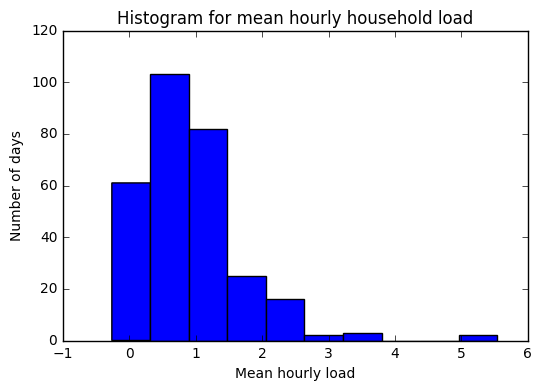

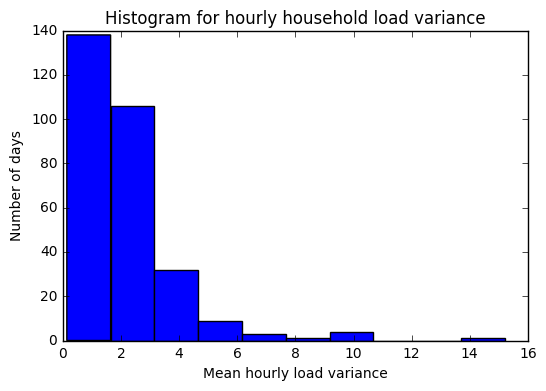

In [36]:
plt.hist(households.mean())  
plt.title("Histogram for mean hourly household load")
plt.xlabel('Mean hourly load')
plt.ylabel('Number of days')
plt.show()   
plt.title("Histogram for hourly household load variance")
plt.xlabel('Mean hourly load variance')
plt.ylabel('Number of days')
plt.hist(households.var()) 
plt.show()  

Except for some small bars outside of the main distribution in both graphs, we have unimodal data, i.e. the values for mean and variance are (by themselves)  just one cluster. 

But we will now look at the relationship between mean and variance.

In [37]:
print("mean daily consumption" ,households.mean().mean()) 
print("mean consumption in high variance households" ,households.T[households.var()>4].T.mean().mean()) 
print("mean consumption in medium variance households" ,households.T[(households.var()>2) |
                                                                  (households.var()<3)].T.mean().mean()) 
print("mean consumption in low variance households" ,households.T[households.var()<2].T.mean().mean())  

mean daily consumption 0.911692575915
mean consumption in high variance households 1.99983719777
mean consumption in medium variance households 0.911692575915
mean consumption in low variance households 0.794054451891


Nothing really surprsing here: Houses that have higher variance, also have higher means: If you have a higher baseline of consumption, the same percentual deviation leads to higher variation.

We will now look at some scatter plots between variation and mean.

In [38]:
df = pd.DataFrame(households.var()) 
df["var"] = df[0] 
del df[0] 
df1 = pd.DataFrame(households.mean()) 
df1["mean"] = df1[0] 
del df1[0] 
var_mean= df.join(df1) 
var_mean.head(2)

,var,mean
26,1.818657,1.431206
77,1.644399,1.151988


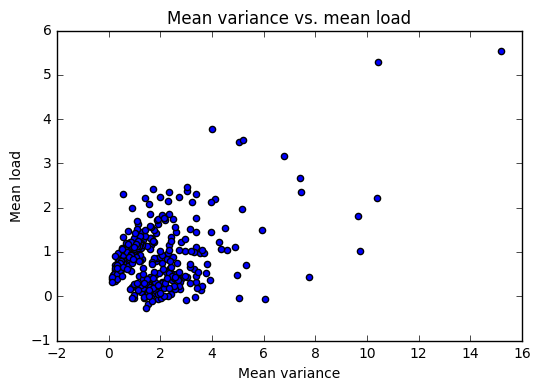

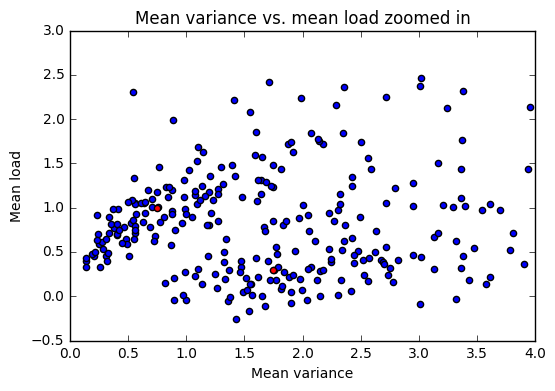

In [39]:
plt.scatter(var_mean["var"], var_mean["mean"])
plt.xlabel('Mean variance')
plt.ylabel('Mean load')
plt.title('Mean variance vs. mean load')
plt.show() 
plt.scatter(var_mean["var"], var_mean["mean"])  
plt.xlabel('Mean variance')
plt.ylabel('Mean load') 
plt.scatter(0.75, 1, c= "r") 
plt.scatter(1.75, 0.3, c= "r")

plt.title('Mean variance vs. mean load zoomed in')
plt.xlim(0,4) 
plt.ylim(-0.5,3)
plt.show()

The first plot suffers from outliers, so let's just look at the zoomed in version: We firstly see a positive relationship between variance and mean load, but what is more interesting is that we can see  two vague blobs 
that do not overlap each other. The approximate centers of those blobs are marked in red.

We will now let k means run on the dataset to get a better idea of how the houses could cluster.

In [40]:
cluster_X = np.column_stack((var_mean["var"], var_mean["mean"])) 

In [41]:
k_max = 10
clusters = []
losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(cluster_X)
    clusters.append(i+1)
    losses.append(model.inertia_)

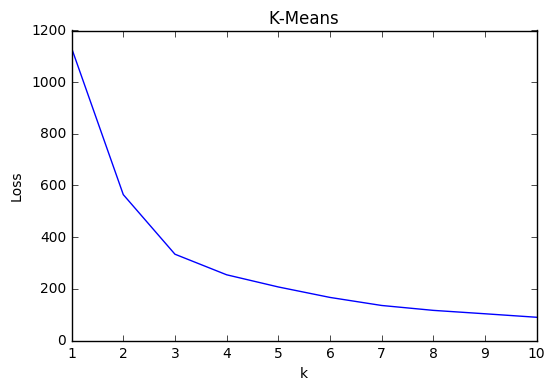

In [42]:
plt.plot(clusters, losses)
plt.title('K-Means')
plt.xlabel('k')
plt.ylabel('Loss')
plt.show()

In [43]:
i=2
model = KMeans(n_clusters=i+1)
model.fit(cluster_X)
model.cluster_centers_

array([[ 1.13953407,  0.76450866],
       [ 9.4258146 ,  2.72328418],
       [ 3.14639038,  1.02352979]])

# These centroids are really not what we are after, why is that? 

Our data does not really fit k-means; as we can see from the plot, we have two elongated blobs that contain the 
majority of the data points, and furthermore we have a small number of houses that are spread all over the place

K-means however uses a squared euclidean distance, which is why outliers have a large effect on the results. Hence we will remove the outliers.

In [44]:
var_mean_low = var_mean[var_mean["var"]<3] #3 based on the graph above makes sense 
var_mean_low = var_mean_low[var_mean_low["mean"]<2] #6 based on the graph above makes sense 
var_mean_low = var_mean_low[(var_mean_low["mean"] <1.5) | (var_mean_low["var"] <2.5 )] 

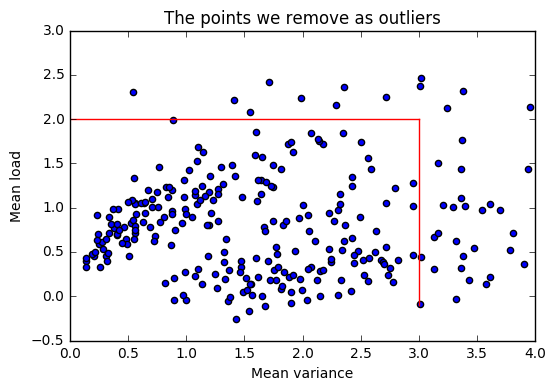

In [45]:
plt.scatter(var_mean["var"], var_mean["mean"])  
plt.xlabel('Mean variance')
plt.ylabel('Mean load')   
plt.plot([3,3], [-0.1,2], c= "r") 
plt.plot([0,3], [2,2], c= "r")
plt.title("The points we remove as outliers") 
plt.xlim(0,4) 
plt.ylim(-0.5,3)
plt.show()

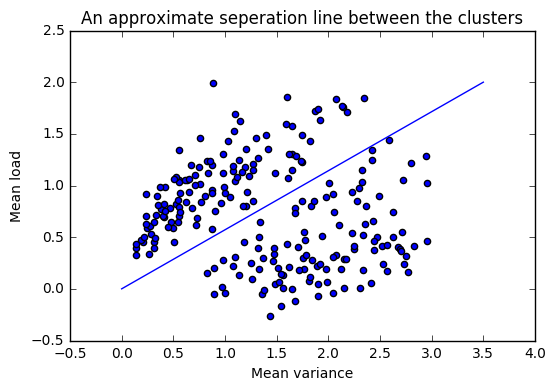

In [46]:
plt.scatter(var_mean_low["var"], var_mean_low["mean"])  
plt.title("An approximate seperation line between the clusters")
plt.plot([0,3.5], [0, 2])
plt.xlabel('Mean variance')
plt.ylabel('Mean load')
plt.show()

After removing the outliers, let's try k-means again.

In [47]:
# prepare for applying k means
var_mean_low =(var_mean_low -var_mean_low.min()) / (var_mean_low.max() - var_mean_low.min())

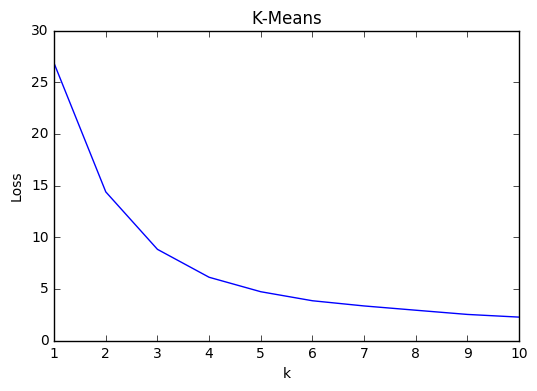

In [48]:
cluster_X =np.column_stack((var_mean_low["var"], var_mean_low["mean"])) 
k_max = 10
clusters = []
losses = []

for i in range(k_max):
    model = KMeans(n_clusters=i+1)
    model.fit(cluster_X)
    clusters.append(i+1)
    losses.append(model.inertia_) 
plt.plot(clusters, losses)
plt.title('K-Means')
plt.xlabel('k')
plt.ylabel('Loss')
plt.show()

In [49]:
i=1
model = KMeans(n_clusters=i+1)
model.fit(cluster_X)
model.cluster_centers_

array([[ 0.67483248,  0.38082225],
       [ 0.22530167,  0.50768908]])

In [50]:
var_mean_low["two_means"] =model.predict(cluster_X)

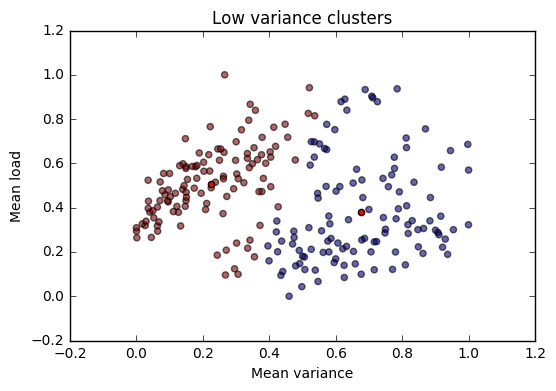

In [51]:
plt.scatter(var_mean_low["var"], var_mean_low["mean"], c= var_mean_low["two_means"], alpha=0.6)   
plt.scatter(model.cluster_centers_.transpose()[0],model.cluster_centers_.transpose()[1], c= "r")
plt.title('Low variance clusters')
plt.xlabel('Mean variance')
plt.ylabel('Mean load')
plt.show()

So the cluster centers look more or less ok, but there are a lot of points in the lower left corner that could actually belong to the other cluster; the reverse happens in the top right corner.

__WHY?__

K-means   expects equally sized clusters, and also that the clusters are more less "spherical", not drawn 
out as in our example. We therefore have to use some other algorithm. During the lecture we talked about Gaussian Mixture Models, which can detect more flexible cluster shapes because the different Gaussian distributions can approximate more function shapes.

We will try to detect three clusters, because there are a few points here with high mean that do not seem to quite fit into the two blobs that we have identified.

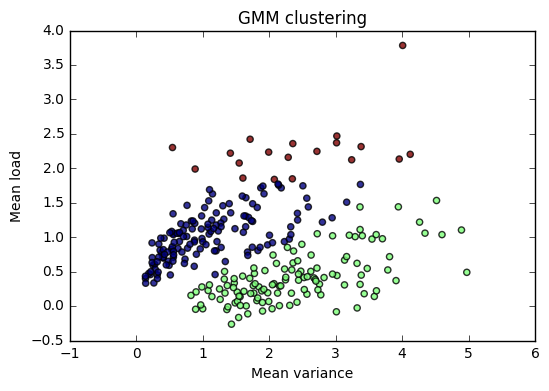

In [76]:
var_mean_medium = var_mean[var_mean["var"]<5]
cluster_X =np.column_stack((var_mean_medium["var"], var_mean_medium["mean"]))  
# due to insufficent data we used covariance_type = "tied" 
# we use random_state so the results can be reproduced
gmm = GaussianMixture(n_components=3, covariance_type="tied", random_state=36).fit(cluster_X)
labels = gmm.predict(cluster_X)

plt.scatter(cluster_X[:, 0], cluster_X[:, 1], c=labels, alpha=0.8)
plt.xlabel('Mean variance')
plt.ylabel('Mean load')
plt.title('GMM clustering')
plt.show()

The GMM performed very well! It was able to capture the lower right green blob and upper left violet blob 
quite accurately. And even better, the yellow dots on top did actually end up in their own cluster. Obviously those are just a few datapoints, but they seem different enough from the blue cluster that they deserver their own. 

We will now investigate what those clusters could represent: At first we focus on the difference between the two large clusters, later on we will focus on the outliers.

Perhaps houses with a higher variance (the green blob) could have solar pannels (sun varies but  consumption patterns not so much) and therefore lower mean.

In [53]:
def group_by_hour(df):  
    """ 
    utility function that helps us to map timestamp to hours
    """
    return  df.index.map(lambda x: x.hour) 
mean_hourly_values =households.groupby(group_by_hour(households)).mean() 
mean_hourly_values.head()

,26,77,86,93,101,114,115,160,171,187,...,9921,9922,9932,9933,9934,9935,9938,9942,9971,9982
0,1.509826,1.170682,0.535562,1.276112,0.477111,0.749835,0.341694,0.565439,0.538212,1.410849,...,0.755323,1.386264,0.715897,1.045848,1.753063,5.932691,2.527455,0.703303,0.858844,0.581676
1,1.169086,1.070650,0.545628,0.972855,0.429477,0.662895,0.299324,0.511348,0.494063,1.279764,...,0.795041,1.216840,0.615047,0.955014,1.733413,5.221510,2.172611,0.635828,0.726216,0.513592
2,1.047179,0.997557,0.558504,0.930942,0.397841,0.735911,0.276455,0.454433,0.466905,1.152267,...,0.577866,1.148360,0.482392,0.935820,1.232214,4.970915,2.011025,0.613034,0.611751,0.477906
3,0.933197,0.958018,0.544159,0.790404,0.368925,0.864692,0.268329,0.442078,0.452374,1.114108,...,0.540176,1.115351,0.457731,0.887689,0.947525,4.838729,1.903069,0.580182,0.491535,0.455567
4,0.881615,0.956154,0.550342,0.842048,0.430877,1.233101,0.265630,0.418818,0.430612,1.071878,...,0.669286,1.067648,0.493665,0.854897,0.828719,4.482649,1.831569,0.592498,0.476458,0.439771


In [75]:
var_mean_medium["three_means"] = labels


/home/ligang/anaconda3/envs/getting_rich/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [54]:
var_mean_medium["three_means"] = labels
first_id =var_mean_medium[var_mean_medium["three_means"] == 0].index.tolist() 
second_id =var_mean_medium[var_mean_medium["three_means"] == 1].index.tolist() 
three_id=var_mean_medium[var_mean_medium["three_means"] == 2].index.tolist()

/home/ligang/anaconda3/envs/getting_rich/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


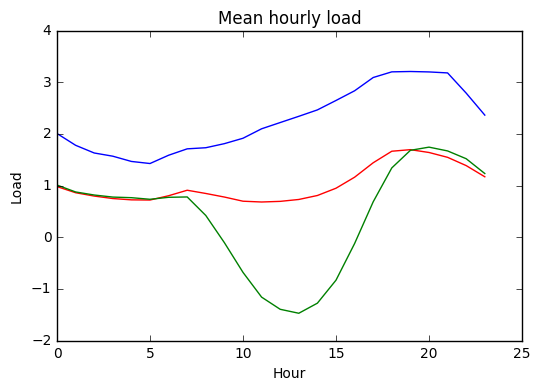

In [55]:
plt.plot(mean_hourly_values.T[mean_hourly_values.T.index.map(lambda x: x in first_id)].mean(), c= "r") 
plt.plot(mean_hourly_values.T[mean_hourly_values.T.index.map(lambda x: x in second_id)].mean() , c= "g") 
plt.plot(mean_hourly_values.T[mean_hourly_values.T.index.map(lambda x: x in three_id)].mean(), c= "b")
plt.title('Mean hourly load')
plt.xlabel('Hour')
plt.ylabel('Load')
plt.show()

The green line represents those with high variance, it seems they have low conumption during the day. First possibility: that's when the sun shines and they produce more energy. Second possibility: nobody is at home.

To evaluate the second possibility let's look at the weekends, where presumably even Americans stay at home (some of them).

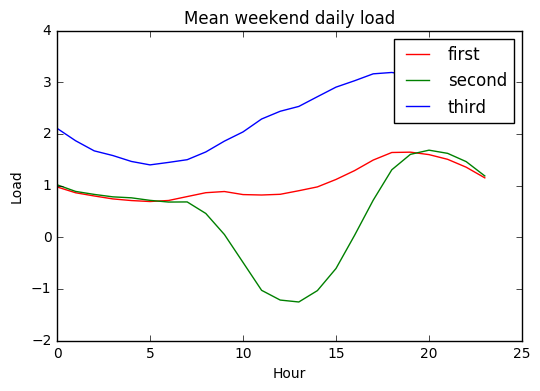

In [56]:
weekend= households[households.index.map(lambda x: x.dayofweek>4) ]
mean_weekend=weekend.groupby(group_by_hour(weekend)).mean() 
plt.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in first_id)].mean(), c= "r", label = "first") 
plt.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in second_id)].mean() , c= "g", label= "second") 
plt.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in three_id)].mean(), c= "b", label = "third") 
plt.legend()
plt.title('Mean weekend daily load')
plt.xlabel('Hour')
plt.ylabel('Load')
plt.show()


# we see exactly the same pattern! This gives further support for the hypothesis that the "green cluster" has solar pannels 

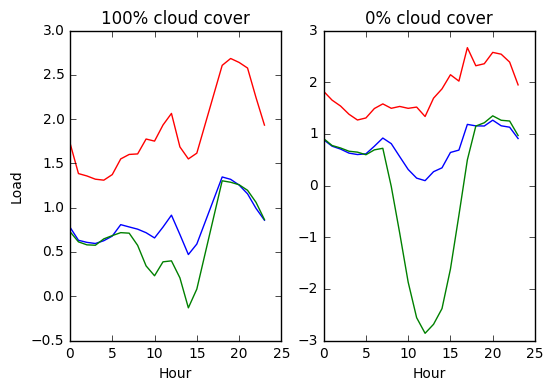

In [58]:
#let's look at cloudy days
ax = plt.subplot(121) 
ax.set_title('100% cloud cover')
ax.set_xlabel('Hour')
ax.set_ylabel('Load')
ax1=plt.subplot(122)
ax1.set_title('0% cloud cover')
ax1.set_xlabel('Hour')

cloud_index=weather[weather["cloud_cover"]==1].index.tolist()
cloud_households =households[households.index.map(lambda x : x in cloud_index)].T  
cloud_by_hour=cloud_households.T.groupby(group_by_hour(cloud_households.T)).mean()
ax.plot(cloud_by_hour.T[cloud_by_hour.T.index.map(lambda x: x in first_id)].mean(),c='b')
ax.plot(cloud_by_hour.T[cloud_by_hour.T.index.map(lambda x: x in second_id)].mean(),c='g') 
ax.plot(cloud_by_hour.T[cloud_by_hour.T.index.map(lambda x: x in three_id)].mean(),c='r')  

cloud_index=weather[weather["cloud_cover"]==0].index.tolist()
cloud_households =households[households.index.map(lambda x : x in cloud_index)].T  
cloud_by_hour=cloud_households.T.groupby(group_by_hour(cloud_households.T)).mean()
ax1.plot(cloud_by_hour.T[cloud_by_hour.T.index.map(lambda x: x in first_id)].mean(),c='b') 
ax1.plot(cloud_by_hour.T[cloud_by_hour.T.index.map(lambda x: x in second_id)].mean(),c='g') 
ax1.plot(cloud_by_hour.T[cloud_by_hour.T.index.map(lambda x: x in three_id)].mean(),c='r')
plt.show()

With high cloud cover we see a much smaller difference between the green and blue line, although it doesn't vanish completely. Reasons might be that even with cloud cover being equal to a 100 percent, there is still sun shinning through.

We now tentatively conclude that the second_cluster has solar pannels, and hence shall be called solar cluster.

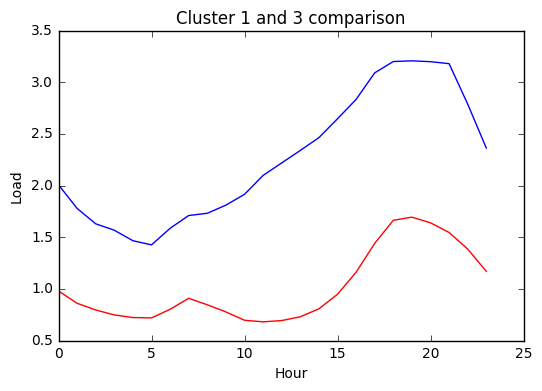

In [59]:
plt.plot(mean_hourly_values.T[mean_hourly_values.T.index.map(lambda x: x in first_id)].mean(), c="r") 
#plt.plot(mean_hourly_values.T[mean_hourly_values.T.index.map(lambda x: x in second_id)].mean() , c= "g") 
plt.plot(mean_hourly_values.T[mean_hourly_values.T.index.map(lambda x: x in three_id)].mean(), c="b")
plt.xlabel('Hour')
plt.ylabel('Load')
plt.title('Cluster 1 and 3 comparison')
plt.show()

Looking at this graph we see similar patterns, but a slight dip after 7 o'clock in the red graph which is not present in the blue graph. We hypothesize that the __blue cluster are households with children__: this would explain why they have higher mean consumption (more people in the house, and larger houses to heat), and 
why they don't have a dip after the morning: maybe only one of the parents is working while the other stays 
at home; also the children retrun somewhere in the afternoon from school.

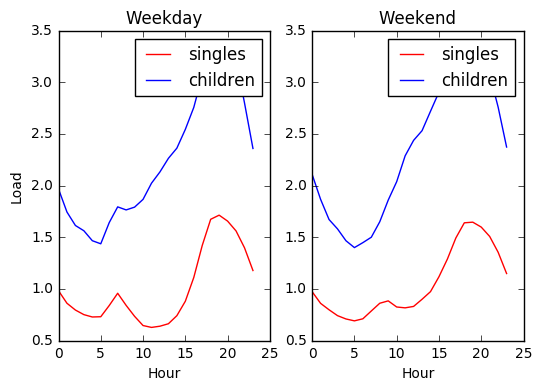

In [60]:
ax = plt.subplot(121)
ax.set_title('Weekday')
ax.set_xlabel('Hour')
ax.set_ylabel('Load')
weekend= households[households.index.map(lambda x: x.dayofweek<=4) ]
mean_weekend=weekend.groupby(group_by_hour(weekend)).mean() 
ax.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in first_id)].mean(), c= "r", label = "singles") 
#plt.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in second_id)].mean() , c= "g", label= "second") 
ax.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in three_id)].mean(), c= "b", label = "children") 
ax.legend()  
ax1 = plt.subplot(122)
ax1.set_title('Weekend')
ax1.set_xlabel('Hour')
weekend= households[households.index.map(lambda x: x.dayofweek>4) ]
mean_weekend=weekend.groupby(group_by_hour(weekend)).mean() 
ax1.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in first_id)].mean(), c= "r", label = "singles") 
#plt.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in second_id)].mean() , c= "g", label= "second") 
ax1.plot(mean_weekend.T[mean_weekend.T.index.map(lambda x: x in three_id)].mean(), c= "b", label = "children") 
ax1.legend()
plt.show()

We can see that in the left graph (the weekday graph) that the dip after 7-8 am is bigger than in the right graph for the first cluster. This is expected and fits our expectations very well.

## PART C - Regression
*Having decided for one cluster and hence a subset of households (which belong to the cluster), perform a regression analysis to estimate the __household mean hourly grid load__ of the cluster. To perform this analysis, use the dataset __'weather.csv'__, which we have already cleaned for you. Describe the features available in the dataset and try to think of other features you might derive from them, which could possibly influence the quality of your regression. Explain your choice of features thoroughly. Evaluate the quality of your prediction/regression using methods learned during the lecture and workshops. Argue why you chose a certain metric of error over other possible metrics. Does your model overfit? Can you tell which features influence the regression most? Why? Have additional features improved your model? Clearly justify your choice of regression model. Can a different regression algorithm yield better results? Why? Which other features that you do not have could be suitable to improve the model? ...*

We will perform a regression on the "Singles" cluster. Therefore we create a table which contains the hourly load values for the households in our cluster. We also add a column with hourly mean values for all households in the cluster.

In [61]:
special_cluster = var_mean_medium[var_mean_medium["three_means"] == 0]
single_households_numbers = special_cluster.index.tolist()
single_households = households.T.loc[single_households_numbers].T
single_households['mean'] = single_households.mean(axis=1)

We now normalize the mean load values and all values in the weather table. We then add the column with the mean daily load values from our cluster to the weather_normalized table. We also add the actual hour as a separate feature.

In [62]:
single_households['mean'] = single_households[['mean']].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
weather_normalized = weather.drop(columns=['summary', 'load', "temp_category", "temp_category_num"]).apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
weather_normalized['summary'] = weather['summary']
weather_normalized['load'] = single_households['mean']
weather_normalized['hour'] = weather_normalized.index.hour

In [63]:
weather_normalized.head()

,temperature,wind_speed,cloud_cover,summary,load,hour
dates,,,,,,
2015-01-01 00:00:00,0.175032,0.378711,1.00,Light Rain,0.318249,0
2015-01-01 01:00:00,0.177440,0.340333,0.95,Light Rain,0.316881,1
2015-01-01 02:00:00,0.173257,0.348298,0.90,Light Rain,0.308594,2
2015-01-01 03:00:00,0.162864,0.343230,0.87,Light Rain,0.288763,3
2015-01-01 04:00:00,0.159316,0.327299,0.90,Light Rain,0.300405,4


Let's get started with the regression. We take the temperature and hour as our x-values. We then divide the set into a train test containing 70% of the data and a test set containing the remaining 30%.

In [64]:
X = np.column_stack([weather_normalized['temperature'], weather_normalized['hour']])
y = np.array(weather_normalized['load'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We will now try to determine the optimal degree for our polynomial regression.
For each degree of the polynomial up to 20 we train our model on the training set, then we predict the load values using the inputs from the training set and compare them to the real load values from the training set using the mean squared error, which we then save into the train_errors list. After that we predict the load values using the inputs from the test set and compare them to the real load values from the test set using the mean sqared error, which is then stored in the test_errors list. 

# Model building approach: 

__Feature selection__: We will start with the two obvious features: temperature and hour. Obviously people consume energy in a different way at night than during the day; temperature was also shown to be highly correlated with load. We *do not include* however cloud cover at this step because we are evaulating the cluster where we assumed that it has no solar panels

__Error function__: For evaluating the performance of our models we choose to use the mean squared error metric as opposed to the absolute error. The mean squared error penalizes large errors much harder than the absolute error; this seems reasonable for a potential business application that we had in mind: if a power company tries to predict the net load on their grid, large deviations could be much more harmful than small deviations, so we will *penalize large errors*.

In [65]:
train_errors = []
test_errors = []
for d in range(20):
    poly_reg = PolynomialFeatures(degree=d)
    x_poly = poly_reg.fit_transform(X_train) 
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, y_train)
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(X_train))
    train_errors.append(mean_squared_error(y_train, y_pred))
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(X_test))
    test_errors.append(mean_squared_error(y_test, y_pred))

Now we can plot both lists on the 2d plane with x-axis representing the degree of the polynomial and y-axis - the mean squared error of the prediction.

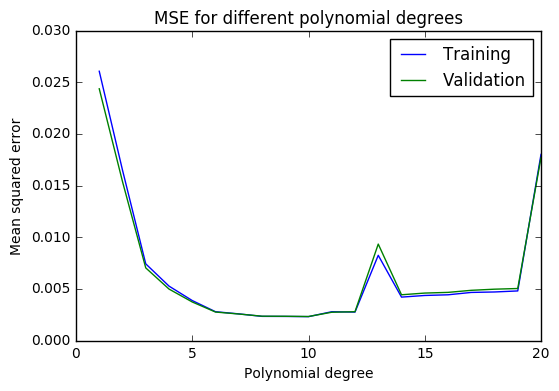

In [66]:
degrees = np.linspace(1, 20, 20)
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.title("MSE for different polynomial degrees")
plt.plot(degrees,train_errors,label='Training')
plt.plot(degrees,test_errors,label='Validation')
plt.legend()
plt.show()

By running the last 3 cells a couple of times (this creates different training and test sets every time), we can conclude that a polynomial of degree 7 looks like a optimal choice, since after that overfitting becomes a problem. We can also take a look a the R^2 value of our model.

In [67]:
poly_reg = PolynomialFeatures(degree=7)
x_poly = poly_reg.fit_transform(X_train)  
x_test = poly_reg.fit_transform(X_test) 
lin_reg_Poly = LinearRegression()
lin_reg_Poly.fit(x_poly, y_train)
y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(X_test))
print('R^2 for the polynomial regression is:', lin_reg_Poly.score(x_test, y_test))

R^2 for the polynomial regression is: 0.903421779174


Let's evaluate the inclusions of different features, and whether they help our model: first try including cloud 
cover:

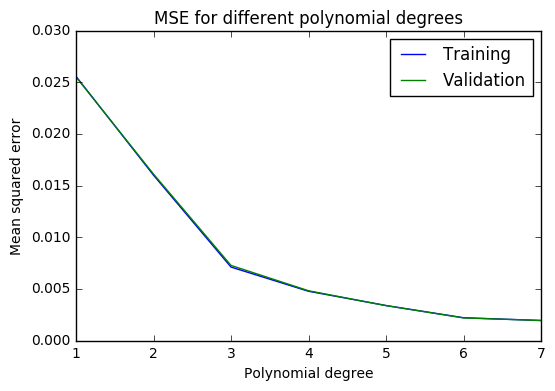

R^2 for the polynomial regression is: 0.93360561789


In [68]:
X = np.column_stack([weather_normalized['temperature'], weather_normalized['hour'],  
                     weather_normalized['cloud_cover']])
y = np.array(weather_normalized['load'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
train_errors = []
test_errors = []
for d in range(7):
    poly_reg = PolynomialFeatures(degree=d)
    x_poly = poly_reg.fit_transform(X_train) 
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, y_train)
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(X_train))
    train_errors.append(mean_squared_error(y_train, y_pred))
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(X_test))
    test_errors.append(mean_squared_error(y_test, y_pred)) 
degrees = np.linspace(1, 7, 7)
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.title("MSE for different polynomial degrees")
plt.plot(degrees,train_errors,label='Training')
plt.plot(degrees,test_errors,label='Validation')
plt.legend()
plt.show() 
poly_reg = PolynomialFeatures(degree=7)
x_poly = poly_reg.fit_transform(X_train)  
x_test = poly_reg.fit_transform(X_test) 
lin_reg_Poly = LinearRegression()
lin_reg_Poly.fit(x_poly, y_train)
y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(X_test))
print('R^2 for the polynomial regression is:', lin_reg_Poly.score(x_test, y_test))

 __Including cloud cover does not increase R^2 substantially, so we choose to not include it__

The exact solution is  x = 0                              
Highest R^2 for the ridge regression is: 0.50154363685


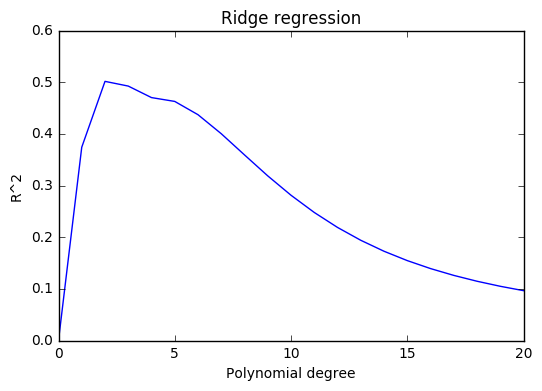

In [70]:
r_squared = []
x = np.linspace(0,20,21)
max_r = 0
for d in range(21):
    Poly = PolynomialFeatures(degree = d)
    X_poly = Poly.fit_transform(X_train)
    model_L2 = Ridge(alpha = 0.01, solver = 'lsqr')
    model_L2.fit(X_poly, y_train)
    y_pred = model_L2.predict(X_poly)
    r_squared.append(model_L2.score(X_poly, y_train))
    if max_r < model_L2.score(X_poly, y_train):
        max_r = model_L2.score(X_poly, y_train)

print('Highest R^2 for the ridge regression is:', max_r)
plt.plot(x, r_squared)
plt.xlabel('Polynomial degree')
plt.ylabel('R^2')
plt.title('Ridge regression')
plt.show()

As we can see, the results of the ridge regression are not impressive.

/home/ligang/anaconda3/envs/getting_rich/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Highest R^2 for the ridge regression is: 0.810483483305


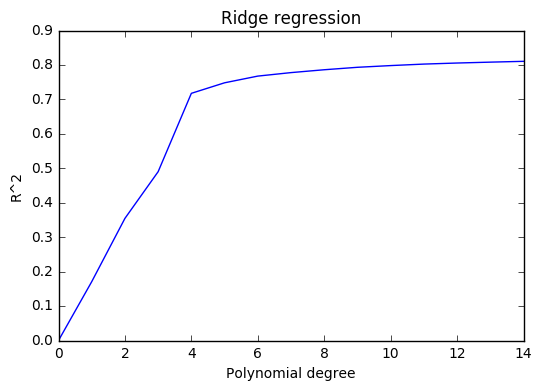

In [71]:
r_squared = []
x = np.linspace(0,14,15)
max_r = 0
for d in range(15):
    Poly = PolynomialFeatures(degree = d)
    X_poly = Poly.fit_transform(X_train)
    model_L1 = Lasso(alpha = 0.1)
    model_L1.fit(X_poly, y_train)
    y_pred = model_L1.predict(X_poly)
    r_squared.append(model_L1.score(X_poly, y_train))
    if max_r < model_L1.score(X_poly, y_train):
        max_r = model_L1.score(X_poly, y_train)

print('Highest R^2 for the ridge regression is:', max_r)
plt.plot(x, r_squared)
plt.xlabel('Polynomial degree')
plt.ylabel('R^2')
plt.title('Ridge regression')
plt.show()

The $R^2$ does not go above 0.8 for the lasso regression. Therefore we decided to use the linear regression with polynomial features as our  prediction model. Due to the low difference between test and training score, we are sure that it does not overfit the data. 

To further improve our result we could try to incorporate information on holidays and humidity because humidity also affects how hot people perceive the temperature to be.